# Task 1: Pacific Tide Gauge Data

---

This is Matt Pudig's notebook for MATH5271 class portfolio task 1. 

In this notebook, we load and analyse one year of hourly data from the _Pacific Sea Level Monitoring Project_ for the Pacific island nation, Kiribati.

_"This task should include at least 3 original figures and approximately 1000 words of text. Your draft should include a solid attempt at parts 1 and 2 and at least a proposed outline of part 3. (The closer your draft is to complete the more useful your peer feedback will be)."_

---

In [851]:
# Import libraries

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd

Section 1.1
---
1.1 _"Download one year of hourly data for one location for the Pacific Sea Level Monitoring Project (http://www.bom.gov.au/oceanography/projects/spslcmp/data/index.shtml) and load these data into a platform such as Google Colaboratory. Briefly describe the source of these data (instruments, procedure, purpose etc) and display/describe the data graphically with one quality figure."_

---

In [852]:
# Load in the csv file from my public github repository: https://github.com/mpudig/MATH5271/tree/main/ClassPortfolio/Task1

url = 'https://raw.githubusercontent.com/mpudig/MATH5271/main/ClassPortfolio/Task1/kiribati_SLR.csv'
df = pd.read_csv(url)

---

The data to be used in this notebook are sourced from Australia Bureau of Meteorology's _Pacific Sea Level Monitoring Project_ (http://www.bom.gov.au/oceanography/projects/spslcmp/data/index.shtml). blah... blah blah ...

---

Section 1.2
---
1.2 _"Investigate these data using frequency domain analysis techniques. For example, fit a discrete number of harmonics to the air and water temperature data and compute the spectral density of the sea-level data. Explain the maths underpinning this analysis and explicitly code at least some of the diagnostics (e.g. write a code to determine Fourier coefficients)."_

---

In [853]:
# Convert the dataframe to xarray for ease (i.e., I know how to use the latter better)

def convert_to_xr_dataset(pd_dataframe):
    # Make into xarray dataset
    ds = pd_dataframe.to_xarray() 
    # Convert the time variable into an xarray dimension
    ds = ds.set_coords(' Date & UTC Time')
    # Remove the old, useless dimension
    ds = ds.drop_vars('index')

    return ds

ds = convert_to_xr_dataset(df)

temp_air = ds['Air Temperature']
temp_water = ds['Water Temperature']
sea_level = ds['Sea Level']

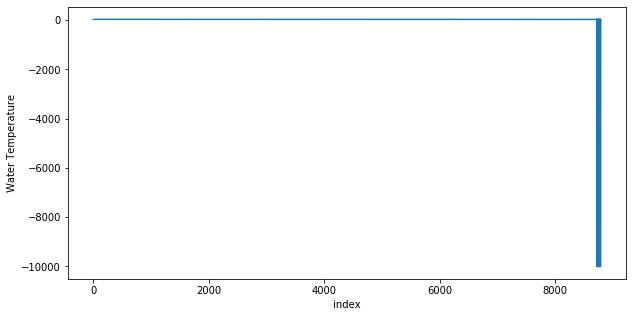

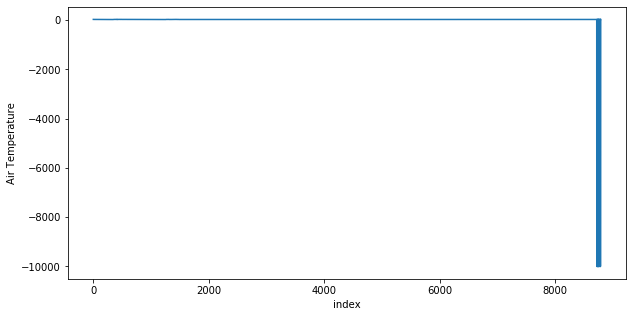

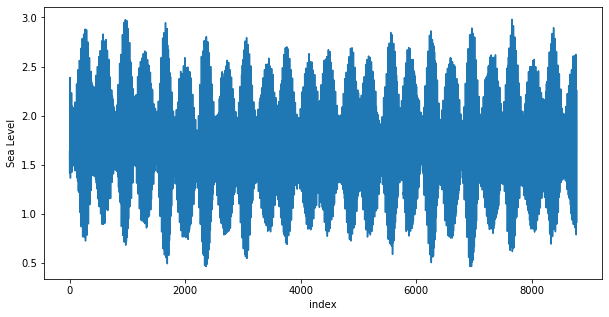

In [854]:
# Plot for exploratory DA

plt.figure(figsize=(10,5))
temp_water.plot()

plt.figure(figsize=(10,5))
temp_air.plot()

plt.figure(figsize=(10,5))
sea_level.plot()

Something going awry with some data points... Let's plot the distribution

(array([  24.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        8760.]),
 array([-9999.  , -8995.95, -7992.9 , -6989.85, -5986.8 , -4983.75,
        -3980.7 , -2977.65, -1974.6 ,  -971.55,    31.5 ]),
 <a list of 10 Patch objects>)

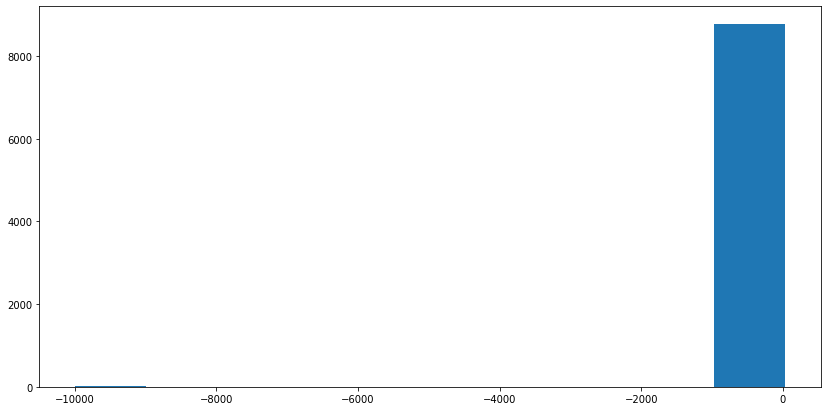

In [855]:
plt.figure(figsize=(14,7))
plt.hist(temp_water)

Let's remove all datapoints that are, e.g., less than -100 and greater than 100.

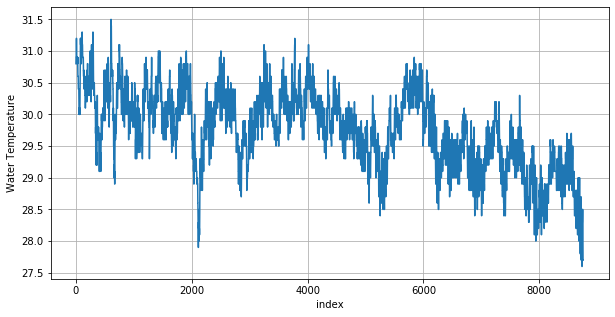

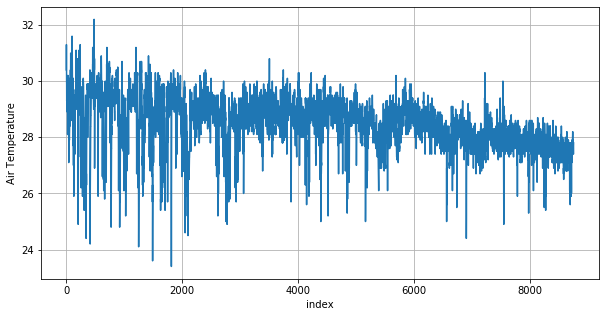

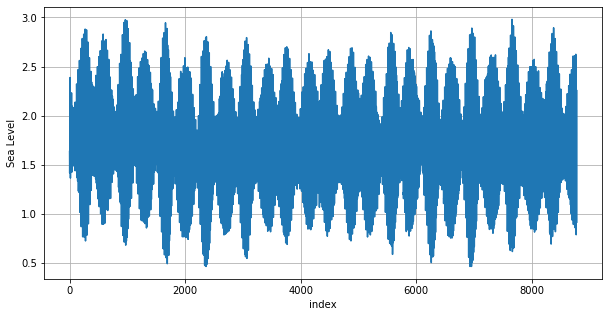

In [856]:
def remove_impossible_vals(array):
    # Returns array such that all values in array are >= -100 *and* <= 100
    
    return array[(array >= -100) & (array <= 100)] 

temp_air = remove_impossible_vals(temp_air)
temp_water = remove_impossible_vals(temp_water)
sea_level = remove_impossible_vals(sea_level)

plt.figure(figsize=(10,5))
temp_water[ : ].plot()
plt.grid()

plt.figure(figsize=(10,5))
temp_air[ : ].plot()
plt.grid()

plt.figure(figsize=(10,5))
sea_level.plot()
plt.grid()

In [857]:
temp_air_zeromean = temp_air - np.mean(temp_air)
temp_water_zeromean = temp_water - np.mean(temp_water)
sea_level_zeromean = sea_level - np.mean(sea_level)

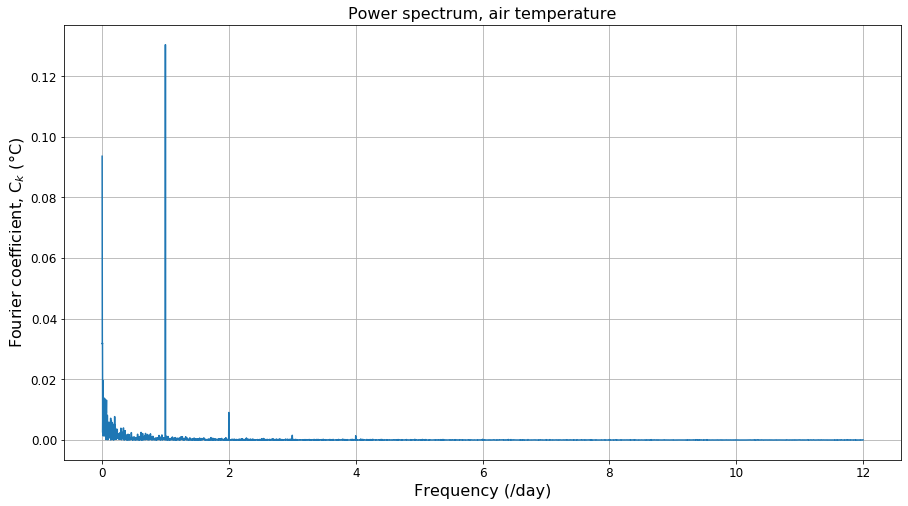

In [866]:
# Compute the power spectrum of air temp

data = temp_air_zeromean
n = data.size
spec = np.fft.rfft(data, n) / (n / 2)

R2_k = (n / 2) * abs(spec[1 : int(n / 2)])**2 / ((n - 1) * np.var(data, ddof=1).values)

plt.figure(figsize=(15,8))
# plt.plot(np.arange(1, int(n / 2)) / (n / 24), abs(spec[1 : int(n / 2)]))
plt.plot(np.arange(1, int(n / 2)) / (n / 24), R2_k)
plt.title('Power spectrum, air temperature', fontsize=16)
plt.ylabel('Fourier coefficient, C$_k$ ($\degree$C)', fontsize=16)
plt.xlabel('Frequency (/day)', fontsize = 16)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.grid()
plt.show()

In [828]:
abs(temp_air_spec[1 : int(n / 2)])
1/((np.arange(1, int(m / 2)) / (n/24))[0]) * 24

8760.0

In [827]:
1/((np.arange(1, int(m / 2)) / (n/24))[np.argmax(abs(temp_air_spec[1 : int(m / 2)]))]) * 24

24.0

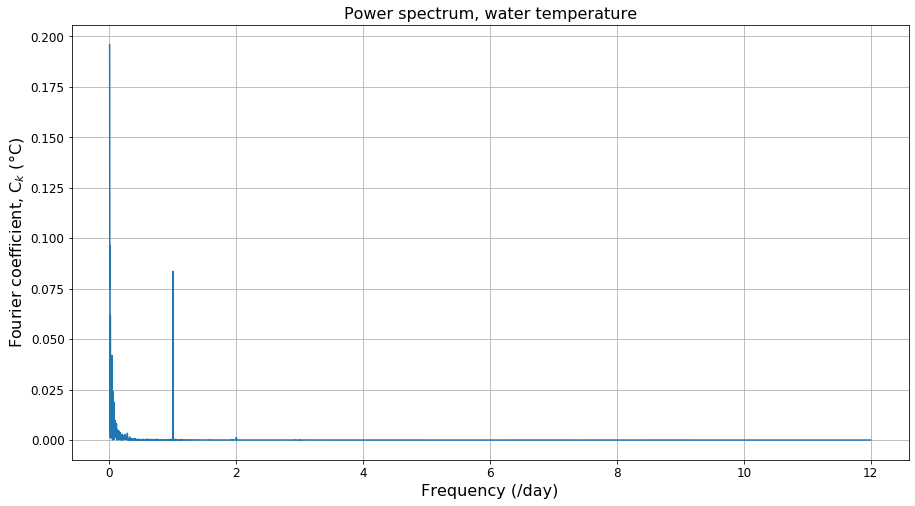

In [868]:
# Compute the power spectrum of air temp

data = temp_water_zeromean

n = data.size
spec = np.fft.rfft(data, n) / (n / 2)
R2_k = (n / 2) * abs(spec[1 : int(n / 2)])**2 / ((n - 1) * np.var(data, ddof=1).values)

plt.figure(figsize=(15,8))
# plt.plot(np.arange(1, int(n / 2)) / (n / 24), abs(spec[1 : int(n / 2)]))
plt.plot(np.arange(1, int(n / 2)) / (n / 24), R2_k)
plt.grid()
plt.title('Power spectrum, water temperature', fontsize=16)
plt.ylabel('Fourier coefficient, C$_k$ ($\degree$C)', fontsize=16)
# plt.ylabel('Normalised spectral density, R$^2_k$', fontsize=16)
plt.xlabel('Frequency (/day)', fontsize = 16)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.show()

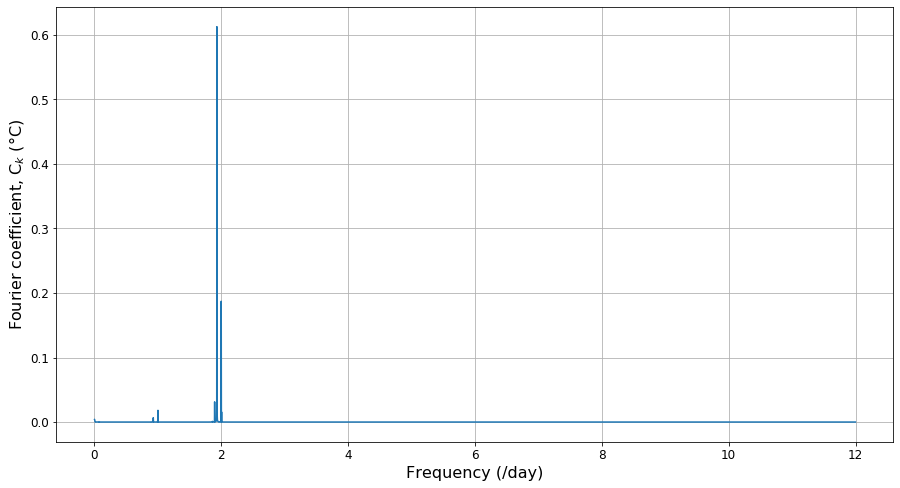

In [877]:
# Compute the power spectrum of the sea level data

data = sea_level_zeromean

n = data.size
spec = np.fft.rfft(data, n) / (n / 2)
R2_k = (n / 2) * abs(spec[1 : int(n / 2)])**2 / ((n - 1) * np.var(data, ddof=1).values)

plt.figure(figsize=(15,8))

# plt.plot(np.arange(1, int(n / 2)) / (n / 24), abs(sea_level_spec[1 : int(n / 2)]))
plt.plot(np.arange(1, int(n / 2)) / (n / 24), R2_k)
# plt.title('Power spectrum, sea level', fontsize=16)
plt.ylabel('Normalised spectral density, R$^2_k$', fontsize=16)
plt.ylabel('Fourier coefficient, C$_k$ ($\degree$C)', fontsize=16)
plt.xlabel('Frequency (/day)', fontsize = 16)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.grid()
plt.show()

In [820]:
print('Thus, the peak power is at a period of ')
1/((np.arange(1, int(m / 2)) / (n/24))[np.argmax(abs(sea_level_spec[1 : int(m / 2)]))]) * 24
#(1/((np.arange(1, int(m / 2)) / (n/24))[np.argmax(abs(sea_level_spec[1 : int(m / 2)]))]) * 24 - 12)*60

Thus, the peak power is at a period of 


12.390381895332393

Section 1.3
---
1.3 _"Interpret these analyses in terms of putative physical processes such as the seasonal cycle and the tides. Discuss what aspects of the results are real physical signals and which could indicate aliasing or similar issues related to the data set."_

---